In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Distribution de la température dans un appartement d'un immeuble aux plusieurs étages


# Équation de transfert de chaleur:
# k*(d^2 T(x,y)/dx^2 + d^2 T(x,y)/dy^2)+S=0


# Conditions aux limites:

# (1) Condition convective (de Robin) à x=0 et à x=Lx (faces externes du mur):
# -k*dT(x=0,y)/dx=-h*(T-Ta)
# -k*dT(x=L,y)/dx=h*(T-Ta)
Ta=-10 #oC

# (2) Condition de Dirichlet sur le plafond et sur le plancher
# T(x, y=0 ou y=Ly)=Tp
Tp=20 #oC

# Dimensions d'appartement
Lx=4 #[m]
Ly=2.4; #[m]

# Parametres d'un mur d'isolation thermique
Lm=0.4 #m ; Épaisseur du mur en brique
km=0.85#W/(m*K); La conductivité thermique de la brique
h=20 #W/(m^2*K); Coefficient de transfert thermique sur les surfaces extérieures du mur

# Paramètres de l'air qui remplit l'appartement
ka=0.024

q=1.0e4;# W/m^3;

d_ar = 0.1*np.array([0.25], dtype=np.double) # Pas en dm
tini_ar=np.zeros(d_ar.size,dtype=np.double)
tinv_ar=np.zeros(d_ar.size,dtype=np.double)
mem_ar=np.zeros(d_ar.size,dtype=np.double)
Tm_ar=np.zeros(d_ar.size,dtype=np.double)
Err_ar=np.zeros(d_ar.size-1,dtype=np.double)
d_Err_ar=np.zeros(d_ar.size-1,dtype=np.double)
def Mindex(i,j): #Associé la case i,j à sa colone dans la matrice M
    index=(j-1)*Ny+i
    return index-1


ci=-1
for d in d_ar:
    ci+=1
    Nx=int(np.rint(Lx/d+1)) # Nombre de nœuds le long de X
    Ny=int(np.rint(Ly/d+1)) # Nombre de nœuds le long de Y


    tic=time.time_ns()
    S=np.zeros((Ny,Nx),dtype=np.double)
    k=np.zeros((Ny,Nx),dtype=np.double)
    
    #Définition de la source et des 
    for i in np.arange(1,Ny+1,1): #i=1,..,Ny - numérotation des nœuds sur un maillage physique
        y=(i-1)*d
        for j in np.arange(1,Nx+1,1): #j=1,..,Nx - numérotation des nœuds sur un maillage physique
            x=(j-1)*d
            
            # Sourse volumique de chaleur q[W/m^3] d'épaisseur dL.
            # La source est intégrée dans les parties intérieures du mur à x=Lm et à x=Lx-Lm et
            # il occupe les tiers du mur dans la direction verticale
            dL=0.1

            if ((x<=Lm) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((x-Lm)/dL)**2)
            elif ((x>=(Lx-Lm)) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((Lx-Lm-x)/dL)**2)
            else:
                # À l'extérieur de l'élément chauffant
                S[i-1,j-1]=0.0
            
            # L'espace de vie de l'appartement est délimité par
            # les parois d'épaisseur Lm à tous les quatre côtés
            if ((x<=Lm) or (x>=(Lx-Lm)) or (y<=Lm) or (y>=(Ly-Lm))):
                # À l'intérieur du mur
                k[i-1,j-1]=km
            else:
                # À l'intérieurde de l'appartement
                k[i-1,j-1]=ka

    M=np.zeros((Nx*Ny,Nx*Ny),dtype=np.double)
    b=np.zeros((Nx*Ny,1),dtype=np.double)
    T=np.zeros((Nx*Ny,1),dtype=np.double)
    Tr=np.zeros((Ny,Nx),dtype=np.double)

    for i in np.arange(1, Ny+1,1):
        y=np.round((i-1)*d, decimals=12)
        for j in np.arange(1, Nx+1,1):
            x=np.round((j-1)*d, decimals=12)

            if y==0:
                # print('y=0')
                M[Mindex(i,j),Mindex(i,j)] = 3+2*d*h/k[i-1,j-1]
                M[Mindex(i,j), Mindex(i+1,j)] = -4
                M[Mindex(i,j), Mindex(i+2,j)] = 1
                b[Mindex(i,j)] = 2*d*h*Ta/k[i-1,j-1]

            elif y==Ly:
                # print('y=ly')
                M[Mindex(i,j),Mindex(i,j)] = 3+2*d*h/k[i-1,j-1]
                M[Mindex(i,j), Mindex(i-1,j)] = -4
                M[Mindex(i,j), Mindex(i-2,j)] = 1
                b[Mindex(i,j)] = 2*d*h*Ta/k[i-1,j-1]

            elif x==0:
                # print('x=0')
                M[Mindex(i,j),Mindex(i,j)] = 3+2*d*h/k[i-1,j-1]
                M[Mindex(i,j), Mindex(i,j+1)] = -4
                M[Mindex(i,j), Mindex(i,j+2)] = 1
                b[Mindex(i,j)] = 2*d*h*Ta/k[i-1,j-1]
            
            elif x==Lx:
                # print('x=lx')
                M[Mindex(i,j), Mindex(i,j)] = 3+2*d*h/k[i-1,j-1]
                M[Mindex(i,j), Mindex(i,j-1)] = -4
                M[Mindex(i,j), Mindex(i,j-2)] = 1
                b[Mindex(i,j)] = 2*d*h*Ta/k[i-1,j-1]

            elif x==Lm:
                # print('x=lm', x)
                M[Mindex(i,j), Mindex(i,j-2)] = km
                M[Mindex(i,j), Mindex(i,j-1)] = -4*km
                M[Mindex(i,j), Mindex(i,j)] = 3*(km+ka)
                M[Mindex(i,j), Mindex(i,j+1)] = -4*ka
                M[Mindex(i,j), Mindex(i,j+2)] = ka

            elif x==Lx-Lm:
                # print('x=lm', x)
                M[Mindex(i,j), Mindex(i,j-2)] = ka
                M[Mindex(i,j), Mindex(i,j-1)] = -4*ka
                M[Mindex(i,j), Mindex(i,j)] = 3*(km+ka)
                M[Mindex(i,j), Mindex(i,j+1)] = -4*km
                M[Mindex(i,j), Mindex(i,j+2)] = km

            elif y==Lm:
                # print('y=lm', y)
                M[Mindex(i,j), Mindex(i-2,j)] = km
                M[Mindex(i,j), Mindex(i-1,j)] = -4*km
                M[Mindex(i,j), Mindex(i,j)] = 3*(km+ka)
                M[Mindex(i,j), Mindex(i+1,j)] = -4*ka
                M[Mindex(i,j), Mindex(i+2,j)] = ka

            elif y==Ly-Lm:
                # print('y=lm', y)
                M[Mindex(i,j), Mindex(i-2,j)] = ka
                M[Mindex(i,j), Mindex(i-1,j)] = -4*ka
                M[Mindex(i,j), Mindex(i,j)] = 3*(km+ka)
                M[Mindex(i,j), Mindex(i+1,j)] = -4*km
                M[Mindex(i,j), Mindex(i+2,j)] = km

            elif (((i>1) and (i<Ny)) and ((j>1) and (j<Nx))):
                M[Mindex(i,j),Mindex(i,j-1)] = 1
                M[Mindex(i,j), Mindex(i,j+1)] = 1
                M[Mindex(i,j), Mindex(i,j)] = -4
                M[Mindex(i,j), Mindex(i-1,j)] = 1
                M[Mindex(i,j), Mindex(i+1,j)] = 1
                b[Mindex(i,j)] = -d**2*S[i-1,j-1]/k[i-1,j-1]
            else:
                print('Erreur dans la définition de la matrice de coefficients')
    toc=time.time_ns()
    tini_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    tic=time.time_ns()
    T=np.linalg.solve(M,b)
    toc=time.time_ns()
    tinv_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    mem_ar[ci]=8*(Nx*Ny)**2
    
    Tr=np.reshape(T,(Ny,Nx),order='F')
    
    Tm_ar[ci]=Tr[int(np.rint(Ly/d/2+1))-1,int(np.rint(Lx/d/2+1))-1]; # température au milieu du domaine de calcul



            
            

7.492608279797292


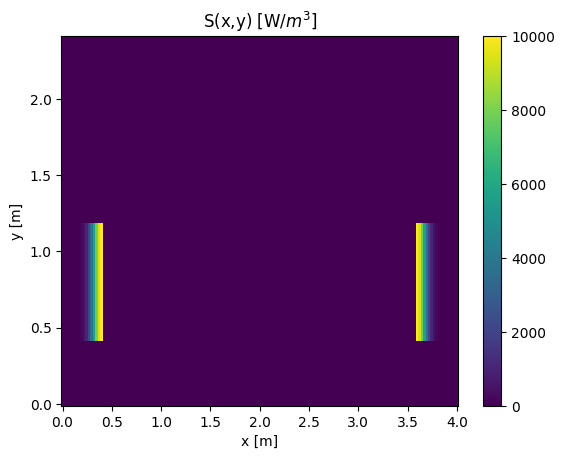

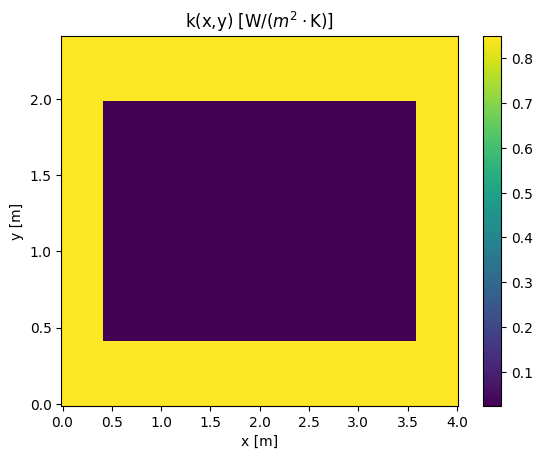

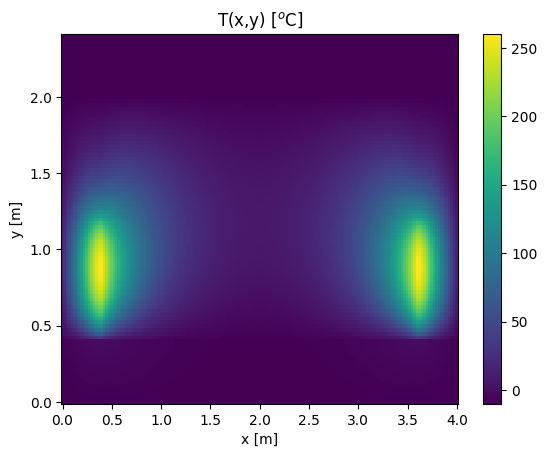

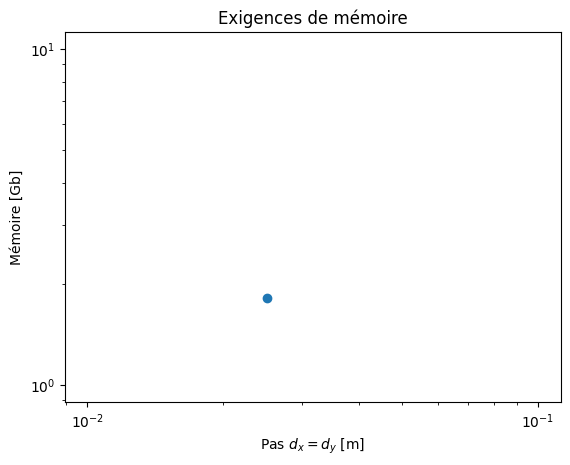

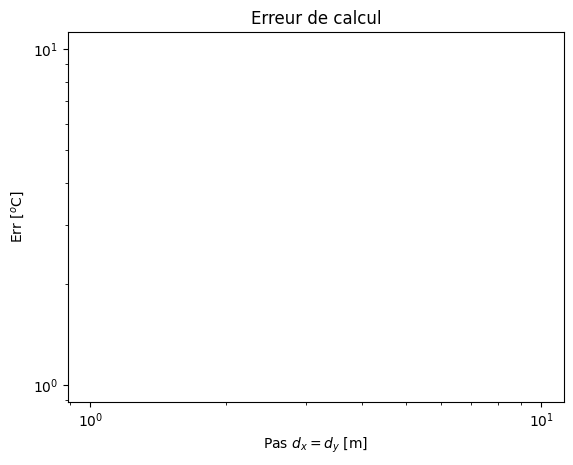

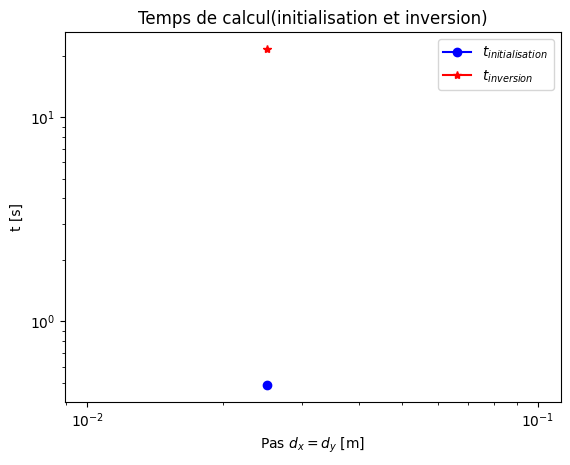

In [17]:
print(Tm_ar[-1])
plt.figure(1)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,S);
plt.colorbar(mappable=None, cax=None, ax=None);
plt.title('S(x,y) [W/$m^3$]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(2)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,k);
plt.colorbar(mappable=None, cax=None, ax=None);
plt.title('k(x,y) [W/($m^2\cdot$K)]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(3)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,Tr);
plt.colorbar(mappable=None, cax=None, ax=None);
plt.title('T(x,y) [$^o$C]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(4)
plt.loglog(d_ar[::-1],mem_ar[::-1]/1024.0**3,'-o')
plt.title('Exigences de mémoire')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Mémoire [Gb]')

plt.figure(5)
Err_ar=abs(Tm_ar[:-1:]-Tm_ar[1::]);
d_Err_ar=d_ar[1::]; # Definiton d'erreur Err(delta)=|Tm(2*delta)-Tm(delta)|
plt.loglog(d_Err_ar[::-1],Err_ar[::-1],'-o')
plt.title('Erreur de calcul')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Err [$^o$C]')

plt.figure(6)
plt.loglog(d_ar[::-1],tini_ar[::-1],'-bo',d_ar[::-1],tinv_ar[::-1],'-r*')
plt.title('Temps de calcul(initialisation et inversion)')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend(['$t_{initialisation}$','$t_{inversion}$'])